# Titration Experiment

In [36]:
# #############################
# #   Experiment parameters   #
# #############################
# ROOT_DIR = '/analysis/gh-msun/'
# PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
# EXPERIMENT = 'primary_immune'
# TITRATING_CELLTYPE = 'Blueprint-B'
# TITRATING_CELLTYPE_ATLAS = 'immune_b' # cell type name in atlas different
# BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
# N_REPLICATES = 2 # number of replicates for each mixture
# SEED = 888 # need to change for different experiment
# TOTAL_READS_TO_SAMPLE = 1000000

# # make sure the orders of the two list match
# CELLTYPES = ['Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-B', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']
# ABRIDGED_NAMES = ['CD4', 'CD8', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# # TITRATION_LIST = [0.2, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
# #                   0.008, 0.006, 0.004, 0.002, 0.001, 0]
# TITRATION_LIST=[0.2, 0.15]

# # proportion of cells in real whole blood (sum to 1)
# WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
#                          'Blueprint-Mono':0.09,
#                          'Blueprint-Neutro':0.57,
#                          'Blueprint-CD4':0.16,
#                          'Blueprint-CD8':0.07,
#                          'Blueprint-NK':0.05}
    

In [39]:
# Parameters
ROOT_DIR = "/analysis/gh-msun/"
PROJECT_SLUG = "2023_06_26_SRT_deconvolution_MS"
EXPERIMENT = "primary_immune_loyfer"
TITRATING_CELLTYPE = "Blood-T"
TITRATING_CELLTYPE_ATLAS = "immune_t"
BACKGROUND = "uniform"
N_REPLICATES = 3
SEED = 83723
TOTAL_READS_TO_SAMPLE = 1000000
# CELLTYPES = ["Blood-B", "Blood-T", "Blood-Mono+Macro"]
# ABRIDGED_NAMES = ["B", "T", "MONOMACRO"]
CELLTYPES = ["Blood-B", "Blood-T", "Blood-Mono+Macro", "Blood-NK"]
ABRIDGED_NAMES = ["B", "T", "MONOMACRO", "NK"]
# CELLTYPES = ['Blueprint-NK', 'Blueprint-B', 'Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-Mono', 'Blueprint-Neutro']
# ABRIDGED_NAMES = ['NK', 'B', 'CD4', 'CD8', 'MONO', 'NEUTRO'] # for directory name
TITRATION_LIST = [0.2, 0.01, 0]
WHOLE_BLOOD_ABUNDANCE = {"Blueprint-B": 0.06, "Blueprint-Mono": 0.09, "Blueprint-Neutro": 0.57, "Blueprint-CD4": 0.16, "Blueprint-CD8": 0.07, "Blueprint-NK": 0.05}


In [40]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-2-b1f9796f075c>:38 

In [3]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [5]:
#################################
#   Set titration proportions   #
#################################

# Reorder such that the titrating cell type comes first
CELLTYPES_unordered = CELLTYPES.copy()
CELLTYPES = hlpr.titration_reordering(list_of_cell_types=CELLTYPES, 
                                      titrating_cell_type=TITRATING_CELLTYPE)

# Reorder abridged name
ABRIDGED_NAMES = hlpr.reorder_abridged_name(unordered_celltypes=CELLTYPES_unordered,
                                            ordered_celltypes=CELLTYPES,
                                            unordered_abridged_names=ABRIDGED_NAMES)
    
# set titration proportions
if BACKGROUND == 'uniform':
    PROPORTIONS = hlpr.generate_uniform_background_proportions(titration_list=TITRATION_LIST, 
                                                               cell_types=CELLTYPES)

if BACKGROUND == 'wholeblood':
    PROPORTIONS = hlpr.generate_custom_background_proportions(titration_list=TITRATION_LIST, 
                                                              custom_proportion=WHOLE_BLOOD_ABUNDANCE, 
                                                              list_of_celltypes=CELLTYPES, 
                                                              titrating_celltype=TITRATING_CELLTYPE)

PROPORTIONS[0]    

[0.2, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666]

## Create mixture

In [6]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [7]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: Blood-T
----------> Loading cell type: Blood-B
----------> Loading cell type: Blood-Mono+Macro
----------> Loading cell type: Blood-NK
>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.2, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
--> PROPORTION: [0.01, 0.33, 0.33, 0.33]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
--> PROPORTION: [0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
>>> Complete. <<< 

CPU times: user 45.4 ms, sys: 8.28 ms, total: 53.6 ms
Wall time: 43.1 s


## Compute score matrix

In [8]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [9]:
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [10]:
%%time
ridxs = ~cpg_map['cpg_index_hg38'].isna()
hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

CPU times: user 15.8 s, sys: 10.4 s, total: 26.1 s
Wall time: 26.1 s


In [11]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

region_df['region_cpg_index_max'] -= 1
region_df.sort_values('region_cpg_index_min', inplace=True)
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [12]:
ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [13]:
cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
ridxs = (cg_count_hg19==cg_count_hg38)
ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1657, 1657)

In [14]:
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [15]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id,region_cpg_index_min_hg38,region_cpg_index_max_hg38
0,chr1,1114771,1114971,20117,20129,Immune_Broad_B-chr1:1114772-1114971,21119,21131
1,chr1,1157450,1157720,21684,21703,Immune_Broad_NK-chr1:1157451-1157720,22686,22705
2,chr1,1157879,1158277,21710,21726,Immune_Broad_NK-chr1:1157880-1158277,22712,22728
14,chr1,6341182,6341377,140667,140681,Immune_Broad_Eosi-chr1:6341183-6341377,142368,142382
19,chr1,9147788,9147871,188605,188608,Immune_Broad_Neutro-chr1:9147789-9147871,190307,190310


In [ ]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       region_df = region_df, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E2T_E2667B_E2667MONOMACRO_E2667NK
--------> Computing score matrix for mix0_seed470800
--------> Computing score matrix for mix1_seed966852
--------> Computing score matrix for mix2_seed995826


--> E01T_E33B_E33MONOMACRO_E33NK
--------> Computing score matrix for mix0_seed327469
--------> Computing score matrix for mix1_seed942713
--------> Computing score matrix for mix2_seed899730


## Deconvolution

In [28]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.loyfer.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.loyfer.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [29]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/primary_immune_loyfer/Blood-T-uniform//methyl_score/'

In [30]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(275, 9)

In [31]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 133 ms, sys: 10.6 ms, total: 144 ms
Wall time: 143 ms


In [29]:
SCORE_PATH1 = SCORE_DIR + 'EB_E3333T_E3333MONOMACRO_E3333NK/mix0_seed997493.tsv.gz'
loyfer_B0 = pd.read_csv(SCORE_PATH1, sep='\t')

In [50]:
dcnv.compute_deconvolution_naive(score_df_path=SCORE_PATH1, filter_cov=20, score_var=SCORE_VAR, ref_region_df=ref_region_df)

ref_celltype
eryth_prog                          0.121197
immune_b                            0.235127
immune_dend_plus_macro_plus_mono    0.106575
immune_eosi                         0.119970
immune_eryth                        0.130285
immune_mega                         0.154375
immune_neutro                       0.154515
immune_nk                           0.128267
immune_t                            0.187473
Name: coeff, dtype: float64

In [30]:
SCORE_PATH2 = SCORE_DIR + 'E2B_E2667T_E2667MONOMACRO_E2667NK/mix0_seed470800.tsv.gz'
loyfer_B20 = pd.read_csv(SCORE_PATH2, sep='\t')

In [51]:
dcnv.compute_deconvolution_naive(score_df_path=SCORE_PATH2, filter_cov=20, score_var=SCORE_VAR, ref_region_df=ref_region_df)

ref_celltype
eryth_prog                          0.121456
immune_b                            0.237792
immune_dend_plus_macro_plus_mono    0.105996
immune_eosi                         0.119606
immune_eryth                        0.135996
immune_mega                         0.162677
immune_neutro                       0.157330
immune_nk                           0.129118
immune_t                            0.173847
Name: coeff, dtype: float64

In [31]:
SCORE_PATH3 = '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/primary_immune/Blueprint-B-uniform/methyl_score/EB_E2CD4_E2CD8_E2NK_E2MONO_E2NEUTRO/mix0_seed912604.tsv.gz'
blueprint_B0 = pd.read_csv(SCORE_PATH3, sep='\t')

In [54]:
dcnv.compute_deconvolution_naive(score_df_path=SCORE_PATH3, filter_cov=20, score_var=SCORE_VAR, ref_region_df=ref_region_df)

ref_celltype
eryth_prog                          0.003064
immune_b                            0.007606
immune_dend_plus_macro_plus_mono    0.164733
immune_eosi                         0.004984
immune_eryth                        0.006437
immune_mega                         0.007576
immune_neutro                       0.183961
immune_nk                           0.193901
immune_t                            0.348516
Name: coeff, dtype: float64

In [32]:
SCORE_PATH4 = '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/primary_immune/Blueprint-B-uniform/methyl_score/E2B_E16CD4_E16CD8_E16NK_E16MONO_E16NEUTRO/mix0_seed10677.tsv.gz'
blueprint_B20 = pd.read_csv(SCORE_PATH4, sep='\t')

In [55]:
dcnv.compute_deconvolution_naive(score_df_path=SCORE_PATH4, filter_cov=20, score_var=SCORE_VAR, ref_region_df=ref_region_df)

ref_celltype
eryth_prog                          0.003423
immune_b                            0.185802
immune_dend_plus_macro_plus_mono    0.135782
immune_eosi                         0.007500
immune_eryth                        0.006425
immune_mega                         0.007271
immune_neutro                       0.141616
immune_nk                           0.152089
immune_t                            0.275966
Name: coeff, dtype: float64

In [39]:
word = 'Broad_B'
loyfer_B0[loyfer_B0['region_id'].str.contains(word)].tail()

,region_id,number_molecules,meth_k1,unmeth_k1,total_k1,meth_k3,unmeth_k3,total_k3,meth_k4,unmeth_k4,total_k4,frac_alpha_leq_25pct,frac_alpha_geq_75pct
1483,Immune_Broad_B-chr21:37608659-37608870,362,1031,55,1086,318,2,362,0,0,0,0.005525,0.878453
1484,Immune_Broad_B-chr3:16475319-16475457,527,19,2751,2770,0,1666,1704,0,1146,1178,0.996205,0.000000
1485,Immune_Broad_B-chr5:6652251-6652334,421,1390,80,1470,526,0,627,157,0,207,0.000000,0.933492
1486,Immune_Broad_B-chr7:403585-403752,977,3117,577,3694,1069,9,1676,397,1,716,0.006141,0.719550
1487,Immune_Broad_B-chr9:35719096-35719254,782,2419,411,2830,778,9,1212,235,4,434,0.008951,0.737852


In [38]:
word = 'Broad_B'
loyfer_B20[loyfer_B20['region_id'].str.contains(word)].tail()

,region_id,number_molecules,meth_k1,unmeth_k1,total_k1,meth_k3,unmeth_k3,total_k3,meth_k4,unmeth_k4,total_k4,frac_alpha_leq_25pct,frac_alpha_geq_75pct
1485,Immune_Broad_B-chr21:37608659-37608870,380,1094,46,1140,341,1,380,0,0,0,0.002632,0.897368
1486,Immune_Broad_B-chr3:16475319-16475457,443,16,2343,2359,0,1429,1457,0,990,1015,0.995485,0.000000
1487,Immune_Broad_B-chr5:6652251-6652334,409,1349,79,1428,522,1,607,167,0,201,0.004890,0.907091
1488,Immune_Broad_B-chr7:403585-403752,992,3269,505,3774,1185,12,1714,469,1,744,0.007056,0.762097
1489,Immune_Broad_B-chr9:35719096-35719254,751,2357,359,2716,782,2,1159,241,0,416,0.003995,0.760320


In [40]:
word = 'Broad_B'
blueprint_B0[blueprint_B0['region_id'].str.contains(word)].tail()

,region_id,number_molecules,meth_k1,unmeth_k1,total_k1,meth_k3,unmeth_k3,total_k3,meth_k4,unmeth_k4,total_k4,frac_alpha_leq_25pct,frac_alpha_geq_75pct
1512,Immune_Broad_B-chr21:37608659-37608870,307,1039,62,1101,419,4,477,149,1,179,0.009772,0.918567
1513,Immune_Broad_B-chr3:16475319-16475457,463,2226,201,2427,1161,14,1429,745,5,951,0.010799,0.870410
1514,Immune_Broad_B-chr5:6652251-6652334,388,1195,173,1368,410,0,575,91,0,204,0.005155,0.858247
1515,Immune_Broad_B-chr7:403585-403752,808,4177,740,4917,2039,43,3148,1325,24,2313,0.014851,0.778465
1516,Immune_Broad_B-chr9:35719096-35719254,408,2140,88,2228,1209,0,1360,809,0,943,0.000000,0.958333


In [41]:
word = 'Broad_B'
blueprint_B20[blueprint_B20['region_id'].str.contains(word)].tail()

,region_id,number_molecules,meth_k1,unmeth_k1,total_k1,meth_k3,unmeth_k3,total_k3,meth_k4,unmeth_k4,total_k4,frac_alpha_leq_25pct,frac_alpha_geq_75pct
1512,Immune_Broad_B-chr21:37608659-37608870,331,930,245,1175,352,70,496,121,26,181,0.160121,0.758308
1513,Immune_Broad_B-chr3:16475319-16475457,464,1771,625,2396,907,272,1418,581,175,948,0.200431,0.693966
1514,Immune_Broad_B-chr5:6652251-6652334,375,949,372,1321,330,94,556,72,32,196,0.181333,0.709333
1515,Immune_Broad_B-chr7:403585-403752,762,3230,1506,4736,1570,622,3079,1005,438,2284,0.213911,0.635171
1516,Immune_Broad_B-chr9:35719096-35719254,362,1544,434,1978,886,217,1214,606,144,847,0.198895,0.762431


In [32]:
deconvolution_nnls[0]

,0,1,2
ref_celltype,,,
immune_eosi,0.103913,0.104585,0.105166
immune_eryth,0.014582,0.012570,0.017590
immune_mega,0.080691,0.092262,0.084266
eryth_prog,0.119276,0.118890,0.118074
immune_b,0.242153,0.237382,0.243314
immune_t,0.161939,0.157565,0.156582
immune_dend_plus_macro_plus_mono,0.092225,0.096818,0.097775
immune_nk,0.136478,0.131365,0.122707
immune_neutro,0.151108,0.151297,0.150349


In [33]:
deconvolution_nnls[1]

,0,1,2
ref_celltype,,,
immune_eosi,0.106723,0.103791,0.104916
immune_eryth,0.009365,0.013953,0.007706
immune_mega,0.090124,0.089498,0.083248
eryth_prog,0.118917,0.115963,0.122212
immune_b,0.242668,0.240431,0.239544
immune_t,0.147522,0.145695,0.149723
immune_dend_plus_macro_plus_mono,0.093648,0.116200,0.093661
immune_nk,0.120969,0.124472,0.122421
immune_neutro,0.156348,0.151232,0.155057


In [34]:
deconvolution_nnls[2]

,0,1,2
ref_celltype,,,
immune_eosi,0.105439,0.107457,0.104998
immune_eryth,0.000326,0.012159,0.006322
immune_mega,0.084536,0.084197,0.082087
eryth_prog,0.124676,0.119679,0.121530
immune_b,0.239446,0.240129,0.240431
immune_t,0.153473,0.150707,0.147823
immune_dend_plus_macro_plus_mono,0.098712,0.092713,0.093377
immune_nk,0.121482,0.127879,0.124894
immune_neutro,0.151456,0.146893,0.156568


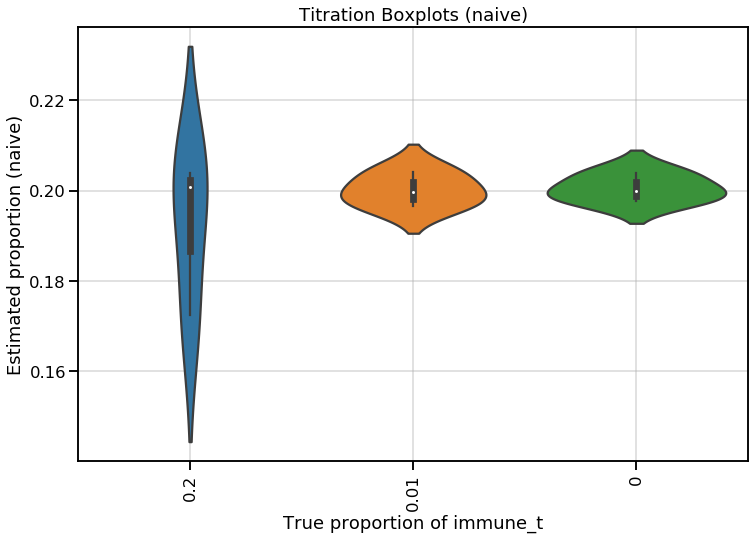

In [35]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

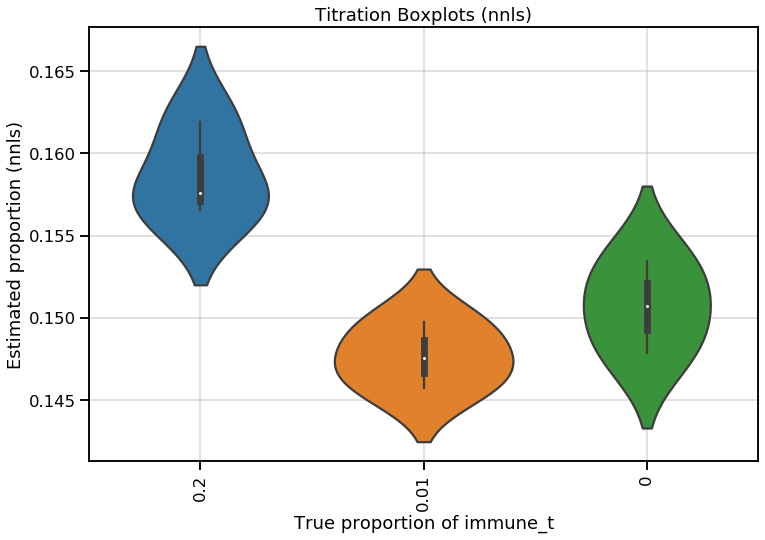

In [36]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

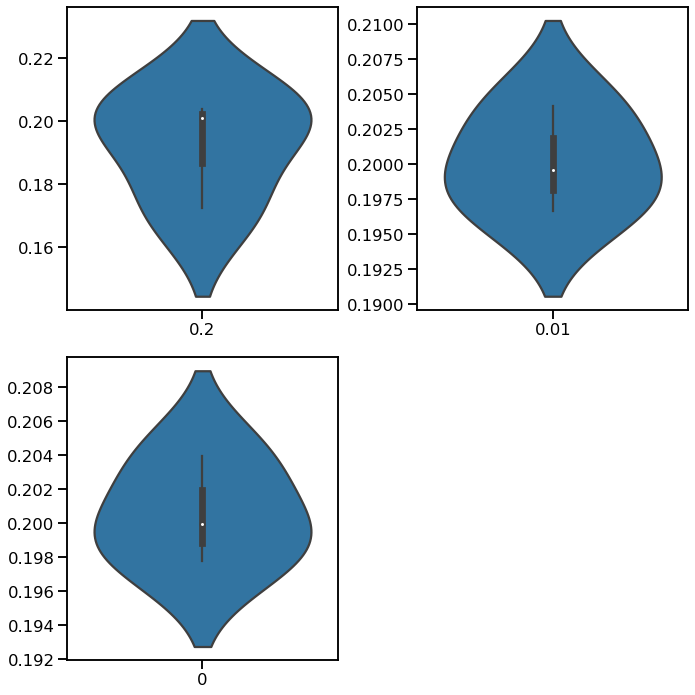

In [37]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

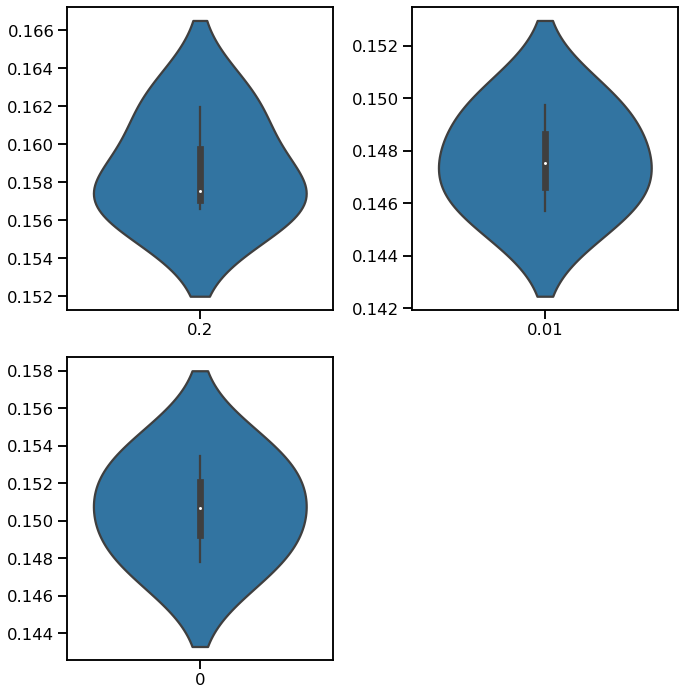

In [38]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )